In [1]:
import os
import math
import requests
import datetime 
import warnings
import pandas as pd
import numpy as np
from statistics import stdev
import matplotlib.pyplot as plt

In [2]:
# Specify directory where data products should be stored
working_directory = '/Users/cdobson/Documents/Github/glider_tools/battery_stats/'
output_directory = os.path.join(working_directory,"output/")

In [3]:
# Import CSV containing OOI deployment metadata
# Can be re-produced with link http://ooi-sparel1.whoi.net/fmc-beta/slapi/deployments/?all=1&format=csv
all_deployments = "/Users/cdobson/Documents/Github/glider_tools/battery_stats/all_deployments.csv"
all_deployments_df = pd.read_csv(all_deployments)

In [4]:
class Deployment:
    """A class to generate and make API calls to the FMC and process the data they return."""
    def __init__(self, glider, dnum, did):
        """Creates data products for a specific deployment of a glider
        :param glider: glider name (e.g. cp_340)
        :param dnum: deployment number 
        :param did: FMC deployment ID
        :return: null
        """
        self.glider = glider
        self.dnum = dnum
        self.did = did
    
    def generate_api_call(self, sensor_id, did):
        """Generates a string to be used as an API call to pull data for a specific sensor and deployment 
        :param sensor_id: sensor ID to pull data for
        :param did: deployment ID to pull data for
        :return api_call: formatted string to be made as an API call to the FMC
        """
        api_call = "http://brookside.whoi.net/fmc-beta/slapi/sensors/?did="+str(did)+"&+sensor_id="+str(sensor_id)+ \
        "&format=csv"
        return(api_call)
    
    def make_api_call(self, api_call):
        """Makes a call to the FMC API 
        :param api_call: formatted string to be made as an API call
        :return response: response from the API call
        """
        response = requests.get(api_call)
        return(response)
    
    def load_to_df(self, api_response):
        """Loads a response from a call to the FMC API into a Pandas dataframe
        :param api_response: response from an API call to the FMC
        :return df: formatted dataframe loaded with data from a FMC API call
        """
        # format the API call data
        response_list = api_response.text.split('\n')
        response_list = [i.split(',') for i in response_list]
        # load the data into a dataframe and clean it up
        df = pd.DataFrame(response_list)
        df = df.rename(columns=df.iloc[0])
        df = df.tail(df.shape[0] -1) 
        df = df.reset_index(drop=True)
        df = df.dropna()
        # add a column that converts timestamps to datetime
        df['datetime'] = pd.to_datetime(df['epoch_seconds'], unit='s')
        return(df)
    
    def convert_df_data_types(self, df, new_type):
        """Converts data types for each applicable column in a dataframe
        :param df: dataframe for which the datatypes will be converted
        :param new_type: new type to convert to
        :return df: dataframe with converted datatypes 
        """
        # Columns to not convert the type of 
        exclude_list = ["index", "glider", "datetime"]
        # Convert the datatypes 
        for (columnName, columnData) in df.iteritems():
            if columnName in exclude_list:
                continue
            else:
                df[columnName] = pd.to_numeric(df[columnName], downcast=new_type)
        return(df)
    
    def calculate_rolling_avg(self, df, sensor_name, interval):
        """Calculates rolling averages over a specified interval
        :param df: dataframe where values are stored
        :param sensor_name: name of column for which averages are to be calculated
        :param interval: interval over which rolling averages should be calculated
        :return dates: list containing dates for which rolling averages were calculated
        :return averages: list containing the rolling averages that were calculated
        """
        # Temporary lists to store data
        dates = []
        averages = []

        # Calculate rolling averages on the supplied data over the specified interval
        for i in df.index:
            # Continue until the time delta is greater than the specified interval
            if (df['epoch_seconds'][i] - df['epoch_seconds'][0]) <  interval:
                continue
            else:
                # Find the first index of the supplied data where the time delta is 
                # is greater than the time interval we are averaging over
                look_back = i
                while ((df['epoch_seconds'][i] - df['epoch_seconds'][look_back]) < interval):
                    look_back-=1
                # When the appopriate index is found, calculate the average of the supplied
                # data over that time interval by calculating the time and data deltas
                time_delta = (df['epoch_seconds'][i] - df['epoch_seconds'][look_back]) / 86400
                data_delta = df[sensor_name][i] - df[sensor_name][look_back]
                data_rate = data_delta / time_delta
                
                # Account for cases where the amphr/day rate may have been negative
                # due to glider resets, manual reset of coloumb counter, etc
                if data_rate < 0:
                    data_rate = math.nan
                
                if data_rate > 3*(np.nanmean(averages)):
                    data_rate = math.nan
            
                # Append the date and average to the lists to be returned
                dates.append(df['datetime'][i])
                averages.append(data_rate)
            
        return(dates, averages)
    
    def get_batt_capacity(self, ref_des, battery_type):
        """Determines the appropriate number to use for the max amphr capacity for a glider
        :param ref_des: reference designator of a glider
        :param battery_type: name of column for which averages are to be calculated
        :return amphr_capacity: the appropriate number to use as max amphr
        """
        if "CP" in ref_des:
            if battery_type == "4s":
                if (("564" in ref_des) or ("583" in ref_des)):
                    amphr_capacity = 800
                else:
                    amphr_capacity = 550
            else:
                if (("564" in ref_des) or ("583" in ref_des)):
                    amphr_capacity = 1050
                else:
                    amphr_capacity = 720
        else: 
            if battery_type == "3s":
                amphr_capacity = 1050
            else: 
                amphr_capacity = 800
        return(amphr_capacity)
    
    def calculate_ideal_rate(self, dates, amphr_capacity, deployment_length):
        """Calculates the ideal amphr/day rate for a specific glider deployment
        :param dates: the list of dates deployed as returned by calculate_rolling_avg
        :param amphr_capacity: the max amphr capacity for a glider
        :param deployment_length: lenght of a deployment in days
        :return ideal_rates: the ideal amphr/day rate for a glider returned as an
            array so that it can be plotted with the dates
        """
        ideal_rate = amphr_capacity / deployment_length
        ideal_rates = np.full_like(dates, ideal_rate)
        return(ideal_rates)
    
    def get_bpump_averages(self, did):
        """Calculates the average ballast used for dives/climbs for a given deployment
        :param did: the deployment ID for the deployment of interest
        :return climb_average: average bpump climb value for a deployment
        :return dive_average: average bpump dive value for a deployment
        """
        # Generate and make the API call to obtain the climb ballast data, then find the average
        climb_api_call = self.generate_api_call(3, did)
        climb_response = self.make_api_call(climb_api_call)
        climb_df = self.load_to_df(climb_response)
        climb_df = self.convert_df_data_types(climb_df, "float")
        
        if 'c_climb_bpump(X)' in climb_df.columns:
            climb_average = str(np.nanmean(climb_df['c_climb_bpump(X)']).round(0))+" cc"
        else: 
            climb_average = "Data not available"
        
        # Generate and make the API call to obtain the dive ballast data, then find the average
        dive_api_call = self.generate_api_call(4, did)
        dive_response = self.make_api_call(dive_api_call)
        dive_df = self.load_to_df(dive_response)
        dive_df = self.convert_df_data_types(dive_df, "float")
        
        if 'c_dive_bpump(X)' in dive_df.columns:
            dive_average = str(np.nanmean(dive_df['c_dive_bpump(X)']).round(0))+" cc"
        else: 
            dive_average = "Data not available"
        
        return(climb_average, dive_average)

cp_389-20151013T2348 didn't work.
cp_387-20151021T1200 didn't work.
cp_388-20150723T2021 didn't work.
gp_514-20150602T1018 didn't work.
cp_374-20150509T1321 didn't work.
cp_376-20150507T0100 didn't work.
cp_340-20150507T0100 didn't work.


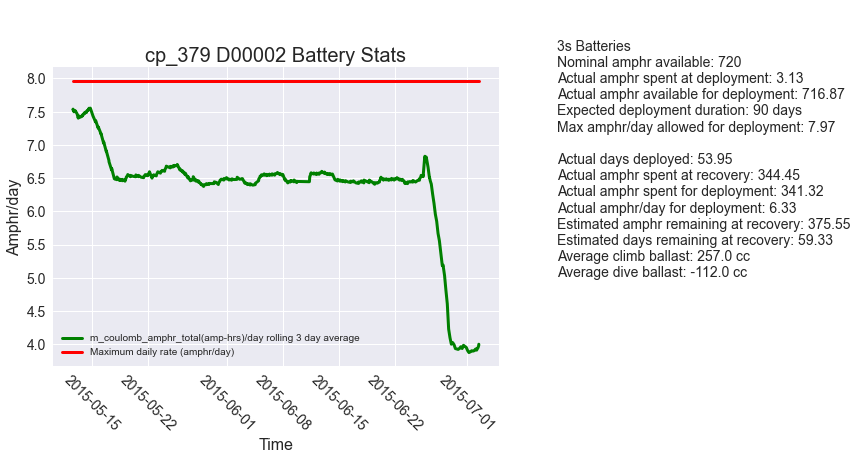

In [5]:
all_deployments_df["file_name"] = " "
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    # Iterate through the deployment metadata csv and process each row
    for index, row in all_deployments_df.iterrows():
        try:
            # Assign the high level deployment metadata
            did = row['deployment_id']
            glider = row['glider_glider_name']
            battery_type = row['batt_type']
            sensor_name = "m_coulomb_amphr_total(amp-hrs)"

            # Weed out Endurance gliders
            if "ce" in glider:
                break
                
            # Skip the rows without official deployment numbers
            if pd.isna(row['dnum']):
                break
            else: 
                deploy_num = str(row['dnum'])

            # Create an instance of Deployment
            deployment = Deployment(glider, deploy_num, did)

            # Expected battery information from deployment metadata 
            deployment.expected_recovery_date = datetime.datetime.fromtimestamp(row['expected_recovery'])
            deployment.actual_deployment_date = datetime.datetime.fromtimestamp(row['start_date_epoch'])
            deployment.expected_deployment_duration = (deployment.expected_recovery_date - deployment.actual_deployment_date).days
            
            # Grab all amphr data from FMC
            deployment.api_call = deployment.generate_api_call(9, deployment.did)
            deployment.api_response = deployment.make_api_call(deployment.api_call)
            deployment.df = deployment.load_to_df(deployment.api_response)
            deployment.df = deployment.convert_df_data_types(deployment.df, 'float')
            deployment.amphr_high = np.nanmax(deployment.df[sensor_name])
            deployment.amphr_low = np.nanmin(deployment.df[sensor_name])
            deployment.amphr_spent = (deployment.amphr_high - deployment.amphr_low).round(2)
            
            # Determine max amphr available for this deployment
            deployment.max_batt_capacity = deployment.get_batt_capacity(glider.upper(), battery_type)
            deployment.amphr_available = (deployment.max_batt_capacity - deployment.amphr_low).round(2)
            # Calculate 3 day rolling average of amphr/day
            deployment.dates, deployment.rates = deployment.calculate_rolling_avg(deployment.df, sensor_name, 259200)
            deployment.ideal_rates = deployment.calculate_ideal_rate(deployment.dates, deployment.amphr_available,
                        deployment.expected_deployment_duration)

            # Calculate the ballast volume averages
            deployment.climb_average, deployment.dive_average = deployment.get_bpump_averages(did)

            # Calculate various battery-related stats
            deployment.days_deployed = ((np.nanmax(deployment.df['epoch_seconds']) - np.nanmin(deployment.df['epoch_seconds'])) \
                / 86400).round(2)
            deployment.amphr_spent_at_recovery = (np.nanmax(deployment.df[sensor_name]) - np.nanmin(deployment.df[sensor_name]))
            deployment.max_rate = ((deployment.amphr_available) / deployment.expected_deployment_duration).round(2)
            deployment.actual_deployment_rate = (deployment.amphr_spent_at_recovery / deployment.days_deployed).round(2)
            deployment.amphr_remaining_at_recovery = (deployment.max_batt_capacity-np.nanmax(deployment.df[sensor_name])).round(2)
            deployment.days_remaining_at_recovery = (deployment.amphr_remaining_at_recovery / deployment.actual_deployment_rate).round(2)

            # Make a line plot of ideal amphr/day rate, rolling 3 day rate and battery stats
            %matplotlib inline
            plt.style.use('seaborn')

            plt.plot(deployment.dates, deployment.rates, color='green', linewidth=3,  
                     label=sensor_name+ "/day rolling 3 day average")
            plt.plot(deployment.dates, deployment.ideal_rates, color='red', linewidth=3, 
                     label = "Maximum daily rate (amphr/day)")

            # modify ticks size
            plt.xticks(fontsize=14, rotation = -45)
            plt.yticks(fontsize=14)
            plt.legend()

            # title and labels
            title = glider+" D"+str(deploy_num.zfill(5))
            plt.title(title+" Battery Stats", fontsize=20)
            #plt.ylim([0, 8])
            plt.xlabel('Time', fontsize=16)
            plt.ylabel('Amphr/day', fontsize=16)

            # place a text box in upper left in axes coords
            textstr = "\n".join([
                    " ",
                    " ",
                     battery_type+" Batteries",
                    "Nominal amphr available: "+str(deployment.max_batt_capacity),            
                    "Actual amphr spent at deployment: "+str(deployment.amphr_low),
                    "Actual amphr available for deployment: "+str(deployment.amphr_available),
                    "Expected deployment duration: "+str(deployment.expected_deployment_duration)+" days",
                    "Max amphr/day allowed for deployment: "+str(deployment.max_rate),
                    " ", 
                    "Actual days deployed: "+str(deployment.days_deployed),
                    "Actual amphr spent at recovery: "+str(deployment.amphr_high),
                    "Actual amphr spent for deployment: "+str(deployment.amphr_spent),              
                    "Actual amphr/day for deployment: "+str(deployment.actual_deployment_rate),
                    "Estimated amphr remaining at recovery: "+str(deployment.amphr_remaining_at_recovery),
                    "Estimated days remaining at recovery: "+str(deployment.days_remaining_at_recovery),
                    "Average climb ballast: "+str(deployment.climb_average), 
                    "Average dive ballast: "+str(deployment.dive_average)
                    ])

            plt.text(1, 0.35, textstr, fontsize=14, transform=plt.gcf().transFigure)

            # save the figure
            file_title = glider+"-D"+str(deploy_num.zfill(5))+"_battery_stats.png"
            plt.savefig(output_directory+file_title, bbox_inches="tight")
            all_deployments_df.at[index, "file_name"] = file_title
        except: 
            print(str(row['deployment_name'])+" didn't work.")